In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from netCDF4 import Dataset,date2num, num2date
import os
import netCDF4
import cartopy.crs as ccrs
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches
import sys

sys.path.append('/scistor/ivm/the410/GolfVijf/')

from GolfVijf.thresholding import *
from GolfVijf.utils import covariance_timeseries2
from GolfVijf.processing import load_and_subset_data, compute_trend_pattern, remove_spatmean_variability, spatial_subset, subdomains

from Tamara_notebooks.compositing import *

In [2]:

path_data='/scistor/ivm/the410/WAVE5'
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"


lower_year, upper_year = 1979, 2024


import warnings
warnings.filterwarnings("ignore")

daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
daJJA.attrs["long_name"]= longname

daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)
daJJA_removed_seasonality.attrs["units"]=unit

daJJA_all = compute_trend_pattern(daJJA_removed_seasonality)

daJJA_cut = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year>=lower_year)
daJJA_cut = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year<=upper_year)

daJJA_cut.attrs["units"]=unit

daJJA_cut_trend = compute_trend_pattern(daJJA_cut)


In [7]:
def _significance_t_test(subset, data_without_subset):
    '''computes two sided t-test, Welch's
    with nan_policy = omit
    a
    returns t and p values
    
    subset= composites
    data is data without subset
    '''
    
    results = ttest_ind(subset, data_without_subset, 
                        equal_var=False, nan_policy="omit")
    
    return results[0], results[1]

def plot_this_VAR_pattern_revised(var_to_plot, VAR_aggregated_data_subset, 
                          VAR_aggregated_positives, VAR_aggregated_positives_mean,
                          week_lag, region, model="ERA5",
                          lower_year=1940, upper_year=2019,
                          sign=True, covar_threshold=0.5,
                         aggregation="weekly", var_to_plot_name=""):
#     sign = True

    year_str= f"{lower_year}_{upper_year}"
    
    if var_to_plot_name == "": 
            var_to_plot_name = var_to_plot 
    
    if model == "ERA5":
        filename=f"{model}_{var_to_plot_name}_{week_lag}_{region}_{covar_threshold}_sign{sign}_{year_str}"
        fname_figure = f"/scistor/ivm/the410/WAVE5/figures/composites_ERA5/{filename}_revised.png"
    else:
        filename=f"{model}_{var_to_plot_name}_{week_lag}_{region}_{covar_threshold}_sign{sign}_{year_str}"
        fname_figure = f"/scistor/ivm/the410/WAVE5/figures/composites_CMIP6/{filename}_revised.png"
        
    if os.path.isfile(fname_figure): #check if plot already exists
        #figure already exists
        print("composite figure already exists")
    else:
        print("composite figure doesn't exists yeat")

        ## FOR VARS T2M, SST, OLR
        assert var_to_plot in ["T2M", "sst", "OLR", "stream", "stream_extended"]
        
        data = VAR_aggregated_positives_mean
        lons = VAR_aggregated_data_subset.longitude
        lats = VAR_aggregated_data_subset.latitude

        sst_title = f"{aggregation} detrended=False, week lag={week_lag}, T-Test={sign}, {year_str}"

        if var_to_plot == "T2M" :
            vmin, vmax = -2, 2
            unit="degr C"
        elif var_to_plot == "sst":
            vmin, vmax = -1, 1
            unit="degr C"
        elif var_to_plot == "OLR":
            vmin, vmax = -60000, 60000
            unit="J m**-2"
        elif var_to_plot == "stream" or var_to_plot == "stream_extended":
            vmin, vmax = -10000000, 10000000
            unit="m2/s"

        if sign:
            t, p = _significance_t_test(VAR_aggregated_positives, VAR_aggregated_data_subset)
#                 data = np.where(p <= 0.05, VAR_aggregated_positives_mean, np.NaN)
            
        title=f"{model} {var_to_plot_name} {lower_year}-{upper_year} {region} \n {sst_title} \n with JJA trend 1979-2023 \n and covar_tresh={covar_threshold}"



        ######
        shading = 'flat'

        cmap = 'RdBu_r'
        fig, ax = plt.subplots(figsize = (20,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
        im = ax.pcolormesh(lons, lats, data[:-1,:-1], transform = ccrs.PlateCarree(),
                                shading = shading, cmap = cmap, vmin=vmin, vmax=vmax)
        if sign:
            hatch = ax.contourf(lons, lats, p, transform = ccrs.PlateCarree(),
                                levels=[0, 0.05, 1],
                                hatches=["...", ""],
                                colors = 'none')
            artists, labels = hatch.legend_elements(str_format='{:2.1f}'.format)
            artist, label = [artists[0]], ["sign."]
            ax.legend(artist, label, handleheight=2, framealpha=1)

        coords = subdomains[region]
        color=colors_dict[region]
        ax.add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                        facecolor='none', edgecolor=color, linewidth=4,
                                        transform=ccrs.PlateCarree()))

        ax.coastlines() 
        ax.set_title(title)
        gl = ax.gridlines(draw_labels = ['left','bottom'])
        gl.xlabel_style = {'size':15}
        gl.ylabel_style = {'size':15}
        fig.colorbar(im, ax=ax, fraction=0.01, pad=0.02, label=f"{unit}")
        plt.show()
        print(fname_figure)
        fig.savefig(fname_figure)

In [1]:
def create_composites_ERA5_revised(var_name, 
                           region, 
                           daJJA_removed_seasonality,
                           daJJA_1979_None_trend,
                           covar_treshold:int=0.5, 
                           stream_azonal:bool=True,
                           lower_year:int= 1950, upper_year:int=2014,
                           time_aggregation:str="weekly",
                           Sign_masked=False,
                           week_lags=[1,2,3]):
    '''
    
    timeperiod here is also influencing over which period we de-seasonalize the data when loading, 
    via the loading functions 
    
    
    '''
    
    print(region, var_name, lower_year, upper_year, time_aggregation)
    
    # load data
    assert var_name in ["T2M", "OLR", "sst", "stream", "stream_extended"] 
    var_name_units = {"T2M":"degr C", "OLR":"J m**-2", "sst":"degr C", 
                      "stream":"m2/s", "stream_extended":"m2/s"}
    
    
    if var_name in ["T2M", "OLR"]:
        data_var_aggr = load_ERA5_var_data(var_name, 
                                           lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    elif var_name == "sst":
        data_var_aggr = load_ERA5_sst_data(lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    elif var_name == "stream":
        data_var_aggr = load_ERA5_stream_data(stream_azonal=stream_azonal,
                                              stream_extended=False,
                          lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    elif var_name == "stream_extended":
        data_var_aggr = load_ERA5_stream_data(stream_azonal=stream_azonal,
                                              stream_extended=True,
                          lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
            
    # get covariance pattern
    data_covars = aggregated_covars_region(region, daJJA_removed_seasonality, daJJA_1979_None_trend, 
                                           lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    #
    ## SET DATA AND SELECT JJA ONLY    
    ## Check if this line is needed or not:
    data_var_aggr = data_var_aggr.sel(time=data_var_aggr.time.dt.month.isin([6,7,8]))
    
    ## 
    indices_bool = np.where(data_covars>covar_treshold, 1, 0) #get boolean timeseries
    time_indices_treshold_excedance = data_covars.time[np.where(data_covars>covar_treshold)] #get time indices
    indices_treshold_excedance = np.where(data_covars>covar_treshold)[0] #get raw indices

    out = {}
    pvals = {}
    
    ## TO FILTER FOR DIFFERENT TIME LAGS 
    for week_lag in week_lags:
        indices_filtered_with_lag = []
        reverse_indices_with_lag = []
        for i in indices_treshold_excedance:
            #print(i, i%13)
            if i%13 >= abs(week_lag):
                #print("don't skip")
                indices_filtered_with_lag.append(i-week_lag)
                reverse_indices_with_lag.append(data_covars.time[i-week_lag].values) #get the corresponding time stamp
            else:
                #print("skip")
                continue
         
        VAR_aggregated_positives = data_var_aggr.values[indices_filtered_with_lag] #get Var of weeks where threshold is exceeded
        VAR_aggregated_positives_mean = VAR_aggregated_positives.mean(axis=0)
        
        #to get the all the data without the subset(composite)
        data_var_aggr_subset = data_var_aggr.drop(reverse_indices_with_lag, dim="time") #get the data without positive matches 
            
        
        if Sign_masked:
            ## If significance mask, to calculate e.g. pattern corrs
            t, p = _significance_t_test(VAR_aggregated_positives, data_var_aggr_subset)
            pvals[week_lag]=p
            VAR_aggregated_positives_mean = np.where(p <= 0.05, VAR_aggregated_positives_mean, np.NaN)
        
        
        out_array = np.zeros((1, data_var_aggr.shape[1], data_var_aggr.shape[2])) 
        out_array[0,:,:]=VAR_aggregated_positives_mean
        xr_out = xr.DataArray(
                data=out_array,
                dims=["time", "latitude", "longitude"],
                coords=dict(
                    time=[0],
                    longitude=data_var_aggr.longitude,
                    latitude=data_var_aggr.latitude),
                attrs=dict(
                    description=f"{var_name} composite anomalies",
                    units=var_name_units[var_name]))
        out[week_lag]=[xr_out, len(indices_filtered_with_lag)] #returning also the nr of positive matches
    
        ##
        # to plot:
        var_to_plot_name = ""
        if var_name == "stream" or var_name == "stream_extended":
            var_to_plot_name = f"{var_name}_azonal={stream_azonal}"
        plot_this_VAR_pattern_revised(var_name, data_var_aggr_subset, 
                          VAR_aggregated_positives, VAR_aggregated_positives_mean,
                          week_lag, region, model="ERA5",
                          lower_year=lower_year, upper_year=upper_year,
                          sign=True, covar_threshold=covar_treshold, 
                          var_to_plot_name=var_to_plot_name)
    
    
    return out, pvals

US_Atl sst 1950 2014 weekly
1950 2014 weekly
US_Atl
(35, 70, -100, 0)
composite figure doesn't exists yeat


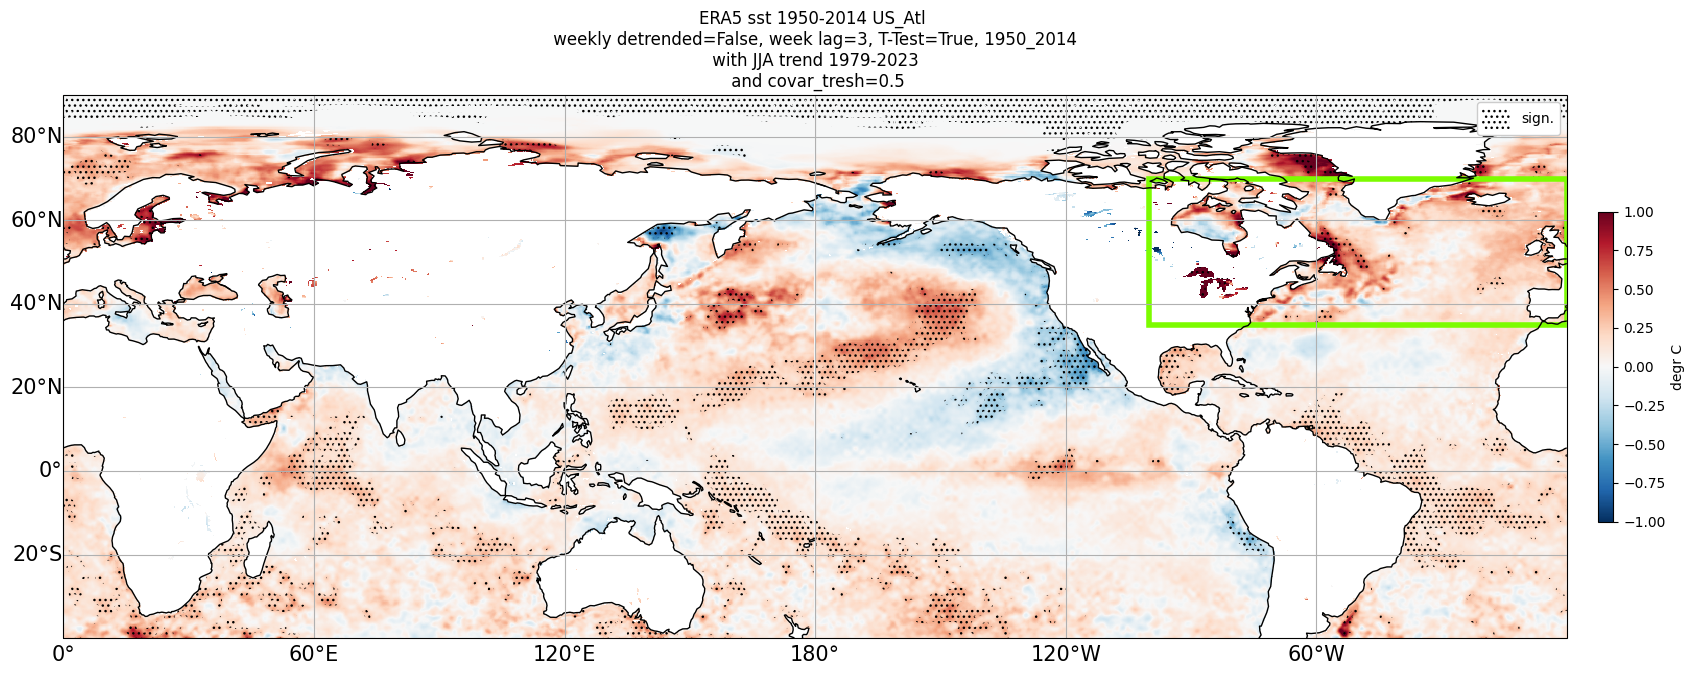

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_sst_3_US_Atl_0.5_signTrue_1950_2014_revised.png


In [23]:
out, pvals  = create_composites_ERA5_revised("sst", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_1979_None_trend,
                   stream_azonal=False,
                   week_lags=[3],
                 lower_year=1950, upper_year=2014)

US_Atl OLR 1950 2014 weekly
US_Atl
(35, 70, -100, 0)
composite figure doesn't exists yeat


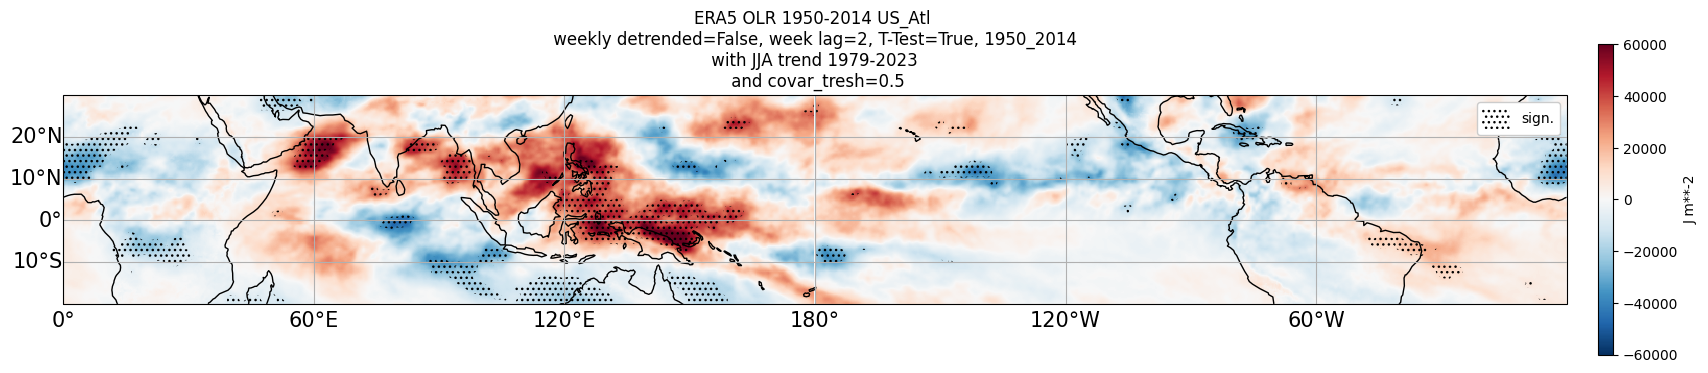

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_OLR_2_US_Atl_0.5_signTrue_1950_2014_revised.png
EURASIA OLR 1950 2014 weekly
EURASIA
(35, 70, 15, 110)
composite figure doesn't exists yeat


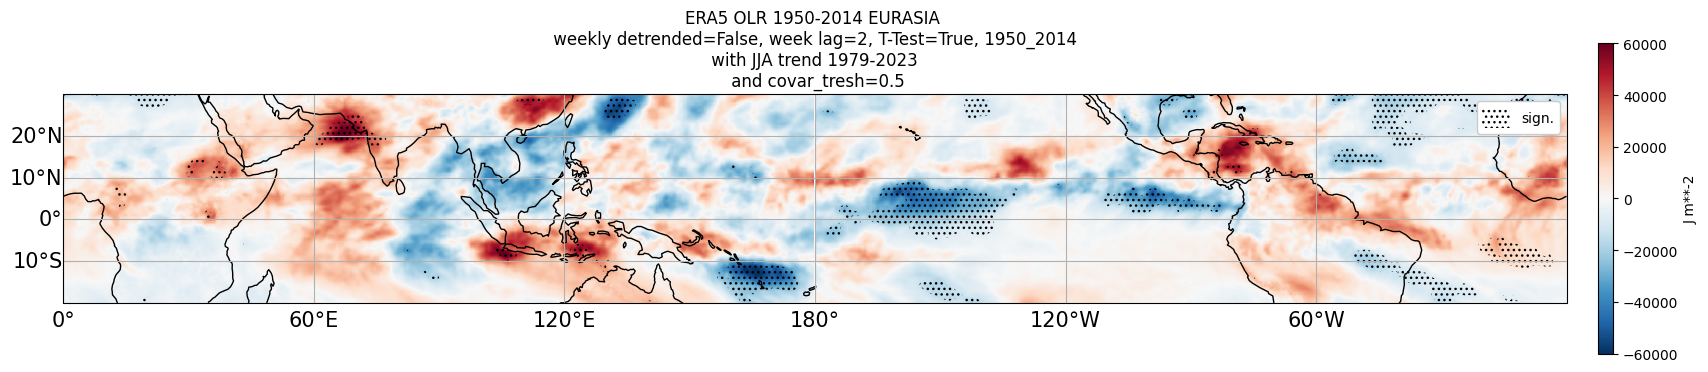

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_OLR_2_EURASIA_0.5_signTrue_1950_2014_revised.png
US_Atl stream_extended 1950 2014 weekly
US_Atl
(35, 70, -100, 0)
composite figure doesn't exists yeat


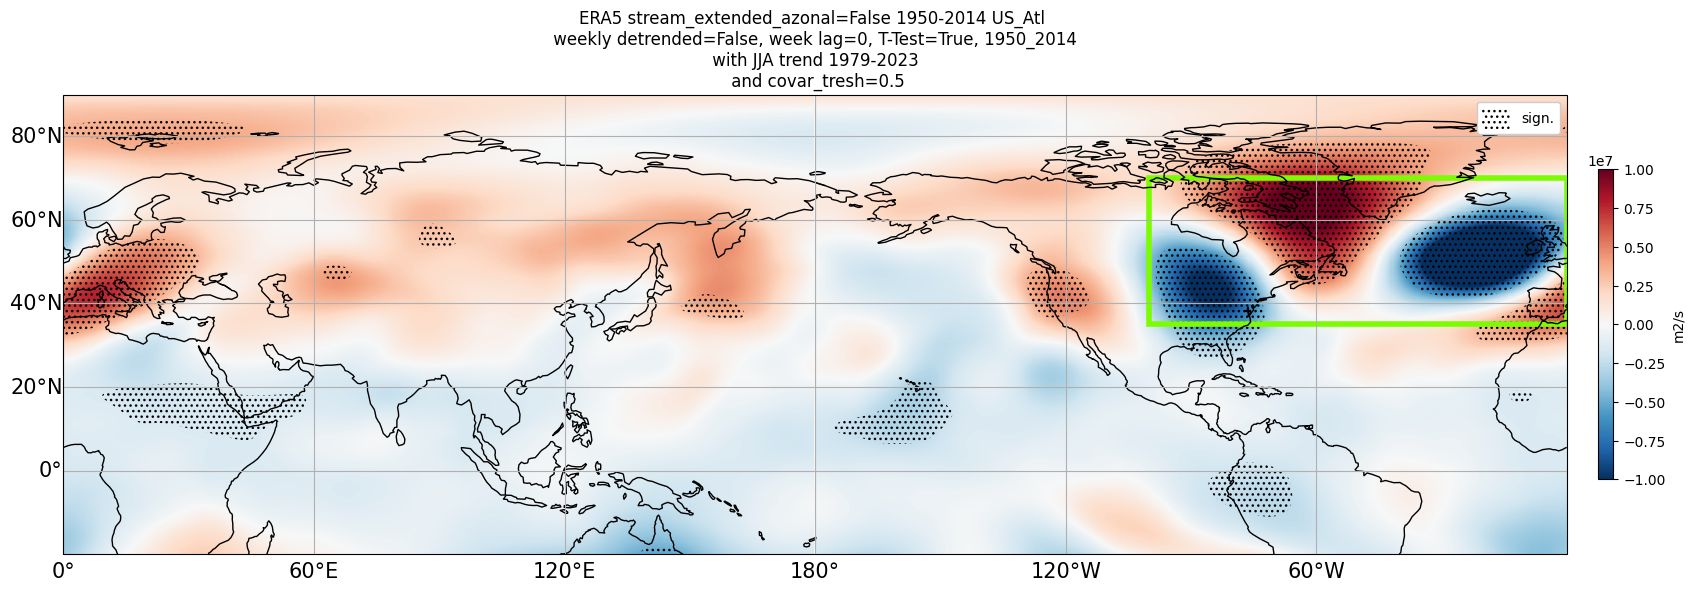

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_stream_extended_azonal=False_0_US_Atl_0.5_signTrue_1950_2014_revised.png
composite figure doesn't exists yeat


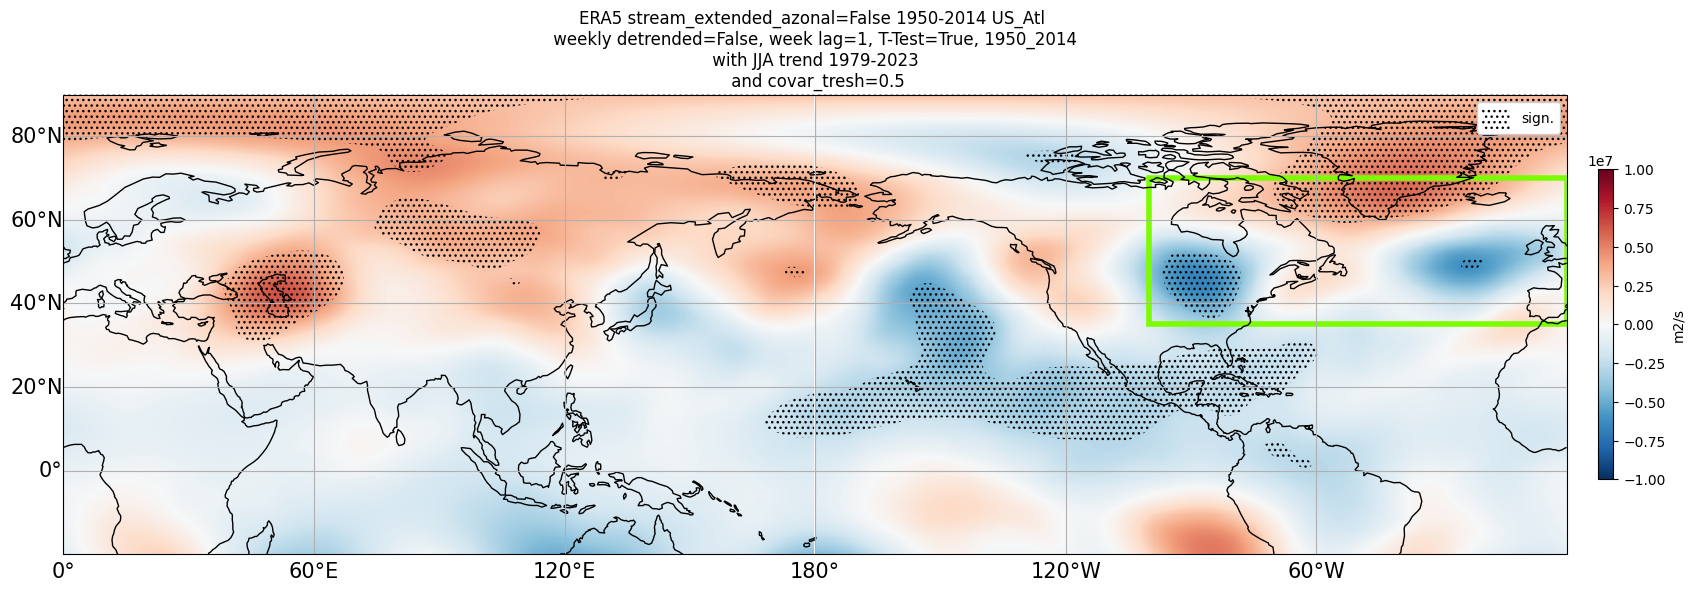

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_stream_extended_azonal=False_1_US_Atl_0.5_signTrue_1950_2014_revised.png
EURASIA stream_extended 1950 2014 weekly
EURASIA
(35, 70, 15, 110)
composite figure doesn't exists yeat


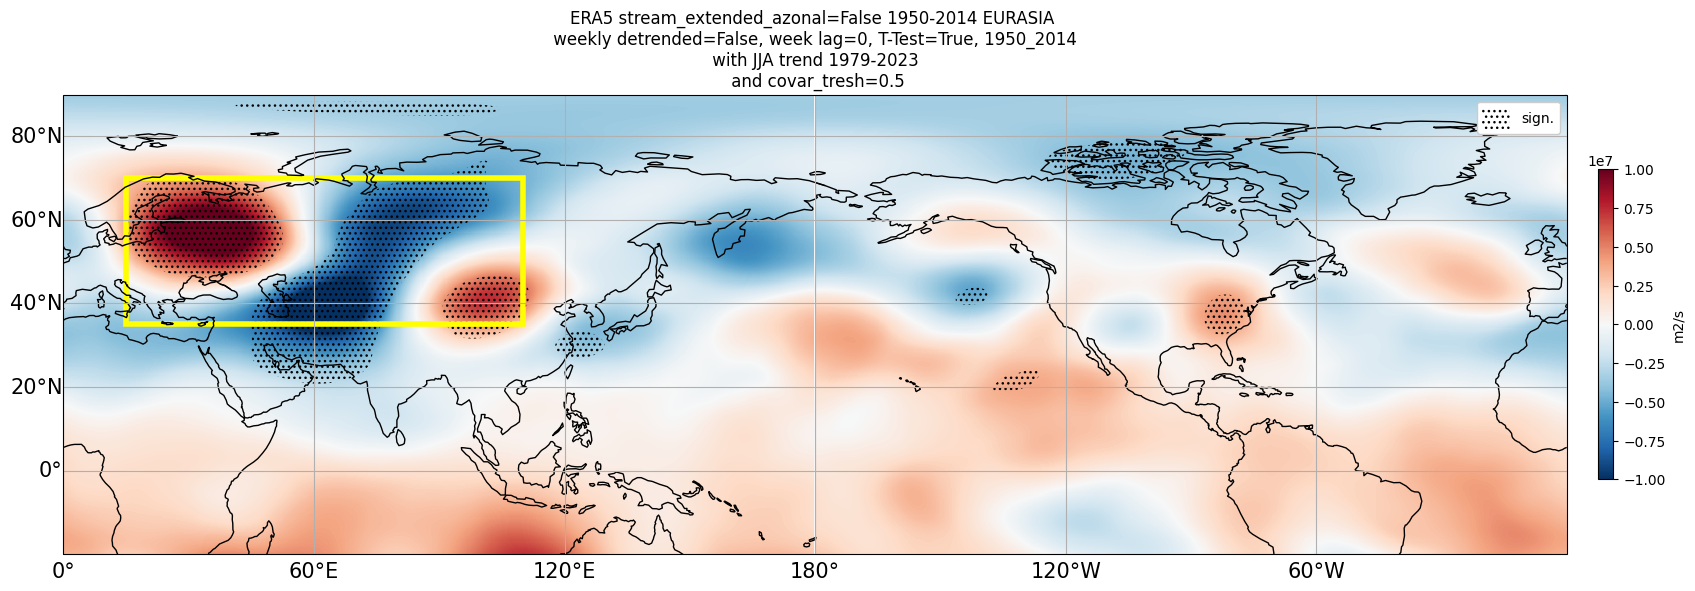

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_stream_extended_azonal=False_0_EURASIA_0.5_signTrue_1950_2014_revised.png
composite figure doesn't exists yeat


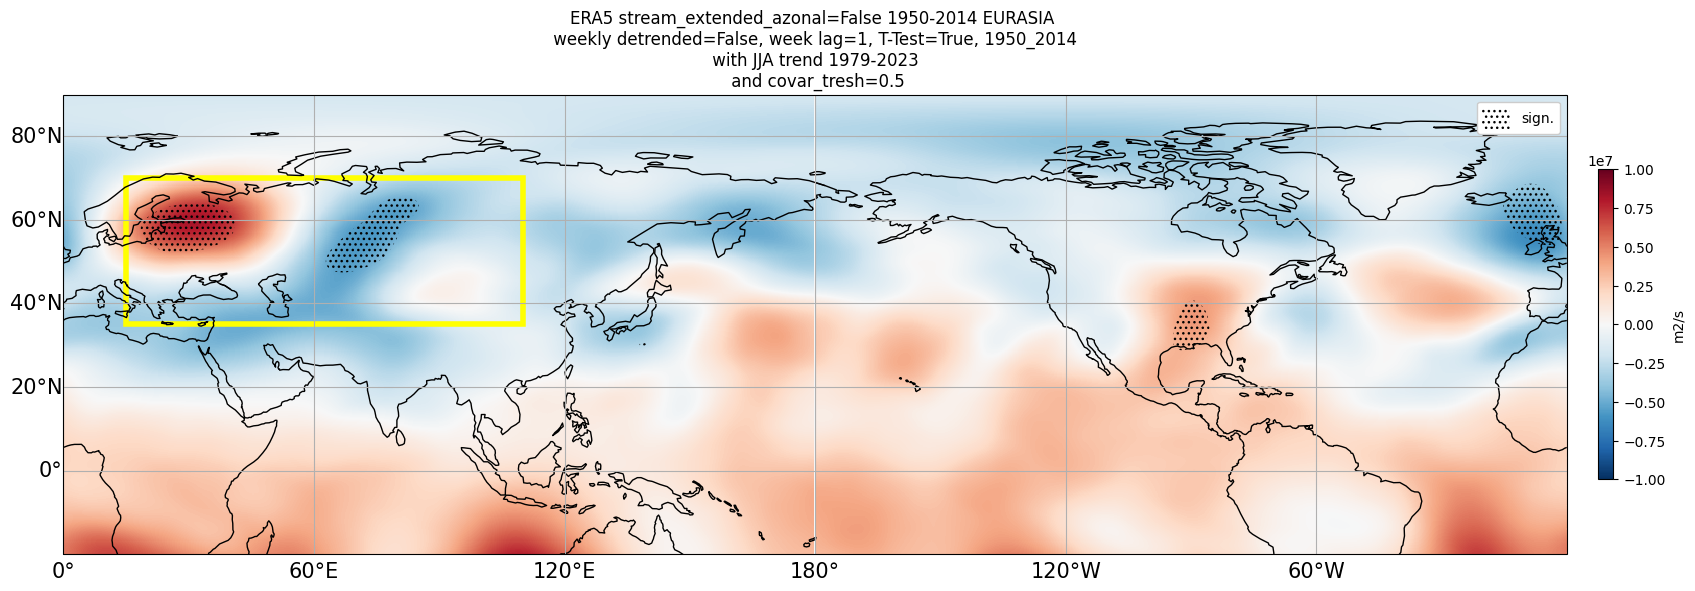

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_stream_extended_azonal=False_1_EURASIA_0.5_signTrue_1950_2014_revised.png
US_Atl T2M 1950 2014 weekly
US_Atl
(35, 70, -100, 0)
composite figure doesn't exists yeat


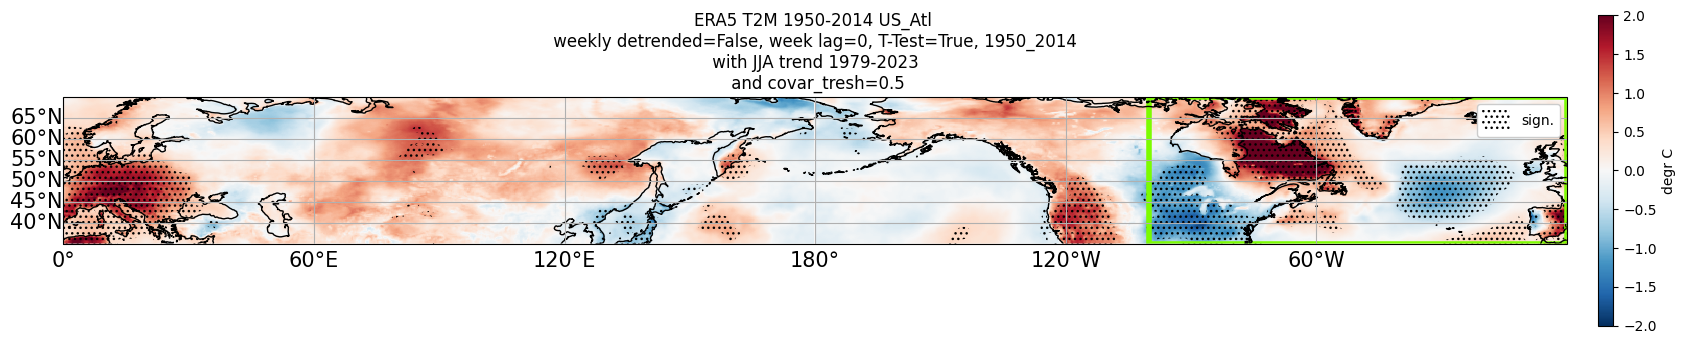

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_T2M_0_US_Atl_0.5_signTrue_1950_2014_revised.png
EURASIA T2M 1950 2014 weekly
EURASIA
(35, 70, 15, 110)
composite figure doesn't exists yeat


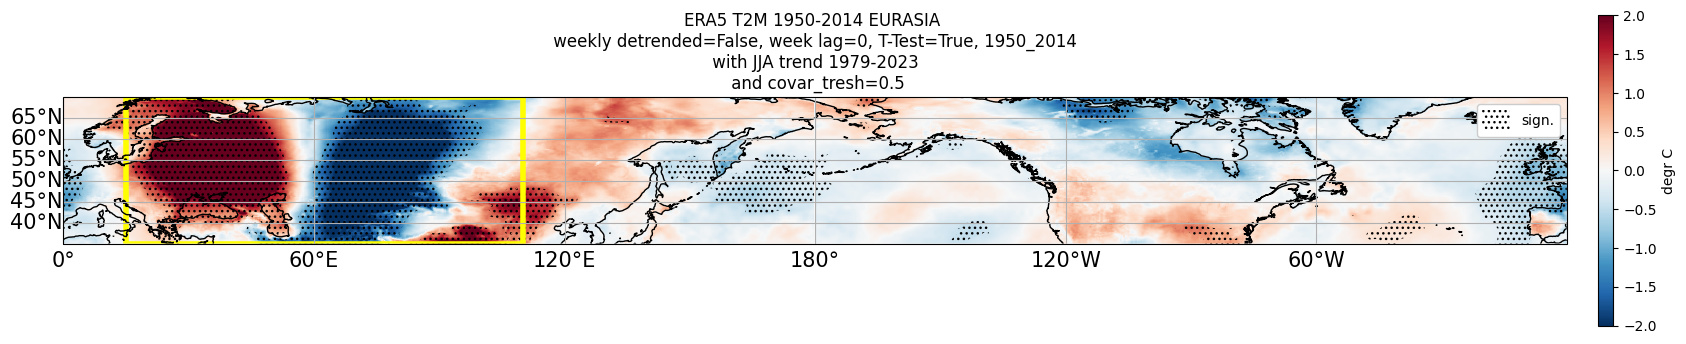

/scistor/ivm/the410/WAVE5/figures/composites_ERA5/ERA5_T2M_0_EURASIA_0.5_signTrue_1950_2014_revised.png


In [24]:
out, pvals  = create_composites_ERA5_revised("OLR", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_1979_None_trend,
                   stream_azonal=False,
                   week_lags=[2],
                 lower_year=1950, upper_year=2014)

out, pvals  = create_composites_ERA5_revised("OLR", 
                   "EURASIA",
                   daJJA_removed_seasonality,
                   daJJA_1979_None_trend,
                   stream_azonal=False,
                   week_lags=[2],
                 lower_year=1950, upper_year=2014)


out, pvals  = create_composites_ERA5_revised("stream_extended", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_1979_None_trend,
                   stream_azonal=False,
                   week_lags=[0, 1],
                 lower_year=1950, upper_year=2014)

out, pvals  = create_composites_ERA5_revised("stream_extended", 
                   "EURASIA",
                   daJJA_removed_seasonality,
                   daJJA_1979_None_trend,
                   stream_azonal=False,
                   week_lags=[0, 1],
                 lower_year=1950, upper_year=2014)

out, pvals  = create_composites_ERA5_revised("T2M", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_1979_None_trend,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1950, upper_year=2014)

out, pvals  = create_composites_ERA5_revised("T2M", 
                   "EURASIA",
                   daJJA_removed_seasonality,
                   daJJA_1979_None_trend,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1950, upper_year=2014)

# now can I create composites of two timeslices for stream250 only, to see if the pattern has intensified? 

In [3]:
def plot_this_VAR_pattern_revised_nosavefig(var_to_plot, VAR_aggregated_data_subset, 
                          VAR_aggregated_positives, VAR_aggregated_positives_mean,
                          week_lag, region, model="ERA5",
                          lower_year=1940, upper_year=2019,
                          sign=True, covar_threshold=0.5,
                         aggregation="weekly", var_to_plot_name=""):
#     sign = True

    year_str= f"{lower_year}_{upper_year}"
    
    if var_to_plot_name == "": 
            var_to_plot_name = var_to_plot 
    

    print("composite figure doesn't exists yeat")

    ## FOR VARS T2M, SST, OLR
    assert var_to_plot in ["T2M", "sst", "OLR", "stream", "stream_extended"]

    data = VAR_aggregated_positives_mean
    lons = VAR_aggregated_data_subset.longitude
    lats = VAR_aggregated_data_subset.latitude

    sst_title = f"{aggregation} detrended=False, week lag={week_lag}, T-Test={sign}, {year_str}"

    if var_to_plot == "T2M" :
        vmin, vmax = -2, 2
        unit="degr C"
    elif var_to_plot == "sst":
        vmin, vmax = -1, 1
        unit="degr C"
    elif var_to_plot == "OLR":
        vmin, vmax = -60000, 60000
        unit="J m**-2"
    elif var_to_plot == "stream" or var_to_plot == "stream_extended":
        vmin, vmax = -10000000, 10000000
        unit="m2/s"

    if sign:
        t, p = _significance_t_test(VAR_aggregated_positives, VAR_aggregated_data_subset)
#                 data = np.where(p <= 0.05, VAR_aggregated_positives_mean, np.NaN)

    title=f"{model} {var_to_plot_name} {lower_year}-{upper_year} {region} \n {sst_title} \n with JJA trend 1979-2023 \n and covar_tresh={covar_threshold}"



    ######
    shading = 'flat'

    cmap = 'RdBu_r'
    fig, ax = plt.subplots(figsize = (20,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    im = ax.pcolormesh(lons, lats, data[:-1,:-1], transform = ccrs.PlateCarree(),
                            shading = shading, cmap = cmap, vmin=vmin, vmax=vmax)
    if sign:
        hatch = ax.contourf(lons, lats, p, transform = ccrs.PlateCarree(),
                            levels=[0, 0.05, 1],
                            hatches=["...", ""],
                            colors = 'none')
        artists, labels = hatch.legend_elements(str_format='{:2.1f}'.format)
        artist, label = [artists[0]], ["sign."]
        ax.legend(artist, label, handleheight=2, framealpha=1)

    coords = subdomains[region]
    color=colors_dict[region]
    ax.add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                    facecolor='none', edgecolor=color, linewidth=4,
                                    transform=ccrs.PlateCarree()))

    ax.coastlines() 
    ax.set_title(title)
    gl = ax.gridlines(draw_labels = ['left','bottom'])
    gl.xlabel_style = {'size':15}
    gl.ylabel_style = {'size':15}
    fig.colorbar(im, ax=ax, fraction=0.01, pad=0.02, label=f"{unit}")
    plt.show()

    
def load_ERA5_var_data_revised(var, lower_year:int = 1940, upper_year:int = 2019, time_aggr:str="weekly",
                      path_data:str='/scistor/ivm/the410/WAVE5'):
    
    ## change the slicing to after the seasonality removed
    
    remove_seasonality = True
    detrending_how_t2m = "None"

    subd_dict = {"T2M":"midlat", "OLR":"tropics"}
    assert var in ["T2M", "OLR"]

    #load data
    VAR = load_and_subset_data(variable = var, months = [6,7,8], subdomain =subd_dict[var], ndays = 1).astype("float32")

    #It makes a difference whether you do the timeslicing before or after the seasonality removal
    VAR = VAR.where(VAR.time.dt.year>=1950, drop=True)
    VAR = VAR.where(VAR.time.dt.year<=2014, drop=True)

    VAR_weekly = VAR.resample(time="1W").mean(skipna=True)

    #remove seasonality
    VAR_weekly_ = VAR_weekly.sel(time=VAR_weekly.time.dt.month.isin([6,7,8])) #to just select JJA
    ## calculate weekly mean, for each gridpoint 
    VAR_weekly_mean = VAR_weekly.groupby(VAR_weekly.time.dt.week).mean(dim="time")
    #to resample to just the summer
    VAR_weekly_mean = VAR_weekly_mean.sel(week=VAR_weekly_mean.week.isin(
        [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,35]) )
    #deseasanlise by removing the weekly mean
    VAR_weekly = VAR_weekly_.groupby(VAR_weekly_.time.dt.week) - VAR_weekly_mean
    
    
    VAR_weekly = VAR_weekly.where(VAR_weekly.time.dt.year>=lower_year, drop=True)
    VAR_weekly = VAR_weekly.where(VAR_weekly.time.dt.year<=upper_year, drop=True)
    
    
    if time_aggr == 'weekly':
        VAR_aggregated = VAR_weekly
    elif time_aggr == 'yearly':
        VAR_aggregated = VAR_weekly.groupby("time.year").mean(dim="time")
    elif time_aggr == "monthly":
        VAR_aggregated = VAR_weekly.groupby("time.month").mean(dim="time")
        VAR_aggregated = VAR_aggregated.where(VAR_aggregated.month.isin([6,7,8]), drop=True)

    return VAR_aggregated

def load_ERA5_stream_data_revised(stream_azonal:bool=True, stream_extended:bool=True,
                          lower_year:int = 1940, upper_year:int = 2019, time_aggr:str="weekly",
                          path_data:str='/scistor/ivm/the410/WAVE5'):

    #LOAD AND/OR AGGREGATE THE CORRECT STREAMFUNCTION DATA
    preprocessing = "seasonality_only" 

    if not stream_extended:
        #load the data
        stream = load_and_subset_data(variable = "STREAM250", months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
        stream_removed_seasonality = remove_spatmean_variability(stream, how=preprocessing)
        
        ## to slice the data 
        stream_removed_seasonality_sliced = stream_removed_seasonality.sel(time=stream_removed_seasonality.time.dt.year>=1950)
        stream_removed_seasonality_sliced = stream_removed_seasonality_sliced.sel(time=stream_removed_seasonality_sliced.time.dt.year<=2014)

        #remove grid point anomalies 
        spatial_mean = stream_removed_seasonality_sliced.mean(axis=0)
        stream_anoms = stream_removed_seasonality_sliced - spatial_mean
        aggregated_stream = stream_anoms.resample(time="1W").mean(dim="time")
        aggregated_stream = aggregated_stream.sel(time=aggregated_stream.time.dt.month.isin([6,7,8]))

    if stream_extended:
        stream_extended = load_and_subset_data(variable = "STREAM250", months = [6,7,8], subdomain = 'nhext', ndays = 1).astype("float32")
        stream_extended_removed_seasonality = remove_spatmean_variability(stream_extended, how=preprocessing)

        stream_removed_seasonality_sliced = stream_extended_removed_seasonality.sel(time=stream_extended_removed_seasonality.time.dt.year>=1950)
        stream_removed_seasonality_sliced = stream_removed_seasonality_sliced.sel(time=stream_removed_seasonality_sliced.time.dt.year<=2014)

        if stream_azonal:
            zonal_mean = stream_removed_seasonality_sliced.mean(axis=(0,2)) #zonal mean over time
            stream_anoms = stream_removed_seasonality_sliced - zonal_mean
        elif not stream_azonal:
            spatial_mean = stream_removed_seasonality_sliced.mean(axis=0) #gridpoint anomalies
            stream_anoms = stream_removed_seasonality_sliced - spatial_mean
        aggregated_stream = stream_anoms.resample(time="1W").mean(dim="time")
        aggregated_stream = aggregated_stream.sel(time=aggregated_stream.time.dt.month.isin([6,7,8]))
        
    aggregated_stream = aggregated_stream.where(aggregated_stream.time.dt.year>=lower_year, drop=True) 
    aggregated_stream = aggregated_stream.where(aggregated_stream.time.dt.year<=upper_year, drop=True) 

    return aggregated_stream

In [11]:
def create_composites_ERA5_revised_nosavefig(var_name, 
                           region, 
                           daJJA_removed_seasonality,
                           daJJA_1979_None_trend,
                           covar_treshold:int=0.5, 
                           stream_azonal:bool=True,
                           lower_year:int= 1950, upper_year:int=2014,
                           time_aggregation:str="weekly",
                           Sign_masked=False,
                           week_lags=[1,2,3]):
    '''
    
    timeperiod here is also influencing over which period we de-seasonalize the data when loading, 
    via the loading functions 
    
    
    '''
    
    print(region, var_name, lower_year, upper_year, time_aggregation)
    
    # load data
    assert var_name in ["T2M", "OLR", "sst", "stream", "stream_extended"] 
    var_name_units = {"T2M":"degr C", "OLR":"J m**-2", "sst":"degr C", 
                      "stream":"m2/s", "stream_extended":"m2/s"}
    
    
    if var_name in ["T2M", "OLR"]:
        data_var_aggr = load_ERA5_var_data_revised(var_name, 
                                           lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    elif var_name == "sst":
        data_var_aggr = load_ERA5_sst_data(lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    elif var_name == "stream":
        data_var_aggr = load_ERA5_stream_data_revised(stream_azonal=stream_azonal,
                                              stream_extended=False,
                          lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    elif var_name == "stream_extended":
        data_var_aggr = load_ERA5_stream_data_revised(stream_azonal=stream_azonal,
                                              stream_extended=True,
                          lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    
    daJJA_removed_seasonality = daJJA_removed_seasonality.where(daJJA_removed_seasonality.time.dt.year>=lower_year, drop=True) 
    daJJA_removed_seasonality = daJJA_removed_seasonality.where(daJJA_removed_seasonality.time.dt.year<=upper_year, drop=True) 
    
#     print(daJJA_removed_seasonality.time)
#     print(data_var_aggr.time)
    
    # get covariance pattern
    data_covars = aggregated_covars_region(region, daJJA_removed_seasonality, daJJA_1979_None_trend, 
                                           lower_year=lower_year, upper_year=upper_year, 
                                           time_aggr=time_aggregation)
    #
    ## SET DATA AND SELECT JJA ONLY    
    ## Check if this line is needed or not:
    data_var_aggr = data_var_aggr.sel(time=data_var_aggr.time.dt.month.isin([6,7,8]))
    
    ## 
    indices_bool = np.where(data_covars>covar_treshold, 1, 0) #get boolean timeseries
    time_indices_treshold_excedance = data_covars.time[np.where(data_covars>covar_treshold)] #get time indices
    indices_treshold_excedance = np.where(data_covars>covar_treshold)[0] #get raw indices

    out = {}
    pvals = {}
    
    ## TO FILTER FOR DIFFERENT TIME LAGS 
    for week_lag in week_lags:
        indices_filtered_with_lag = []
        reverse_indices_with_lag = []
        for i in indices_treshold_excedance:
            #print(i, i%13)
            if i%13 >= abs(week_lag):
                #print("don't skip")
                indices_filtered_with_lag.append(i-week_lag)
                reverse_indices_with_lag.append(data_covars.time[i-week_lag].values) #get the corresponding time stamp
            else:
                #print("skip")
                continue
         
        print("n is:", len(indices_filtered_with_lag))
        VAR_aggregated_positives = data_var_aggr.values[indices_filtered_with_lag] #get Var of weeks where threshold is exceeded
        VAR_aggregated_positives_mean = VAR_aggregated_positives.mean(axis=0)
        
        #to get the all the data without the subset(composite)
        data_var_aggr_subset = data_var_aggr.drop(reverse_indices_with_lag, dim="time") #get the data without positive matches 
            
        
        if Sign_masked:
            ## If significance mask, to calculate e.g. pattern corrs
            t, p = _significance_t_test(VAR_aggregated_positives, data_var_aggr_subset)
            pvals[week_lag]=p
            VAR_aggregated_positives_mean = np.where(p <= 0.05, VAR_aggregated_positives_mean, np.NaN)
        
        
        out_array = np.zeros((1, data_var_aggr.shape[1], data_var_aggr.shape[2])) 
        out_array[0,:,:]=VAR_aggregated_positives_mean
        xr_out = xr.DataArray(
                data=out_array,
                dims=["time", "latitude", "longitude"],
                coords=dict(
                    time=[0],
                    longitude=data_var_aggr.longitude,
                    latitude=data_var_aggr.latitude),
                attrs=dict(
                    description=f"{var_name} composite anomalies",
                    units=var_name_units[var_name]))
        out[week_lag]=[xr_out, len(indices_filtered_with_lag)] #returning also the nr of positive matches
    
        ##
        # to plot:
        var_to_plot_name = ""
        if var_name == "stream" or var_name == "stream_extended":
            var_to_plot_name = f"{var_name}_azonal={stream_azonal}"
        plot_this_VAR_pattern_revised_nosavefig(var_name, data_var_aggr_subset, 
                          VAR_aggregated_positives, VAR_aggregated_positives_mean,
                          week_lag, region, model="ERA5",
                          lower_year=lower_year, upper_year=upper_year,
                          sign=True, covar_threshold=covar_treshold, 
                          var_to_plot_name=var_to_plot_name)
    
    
    return out, pvals

## load streamdata for trend

In [8]:
path_data='/scistor/ivm/the410/WAVE5'
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"


lower_year, upper_year = 1979, 2024


import warnings
warnings.filterwarnings("ignore")

daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
daJJA.attrs["long_name"]= longname

daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)
daJJA_removed_seasonality.attrs["units"]=unit

daJJA_all = compute_trend_pattern(daJJA_removed_seasonality)

daJJA_cut = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year>=lower_year)
daJJA_cut = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year<=upper_year)

daJJA_cut.attrs["units"]=unit

daJJA_cut_trend = compute_trend_pattern(daJJA_cut)


####  Threshold of 0.3 

US_Atl stream 1950 1979 weekly
<xarray.DataArray 'time' (time: 2760)>
array(['1950-06-01T00:00:00.000000000', '1950-06-02T00:00:00.000000000',
       '1950-06-03T00:00:00.000000000', ..., '1979-08-29T00:00:00.000000000',
       '1979-08-30T00:00:00.000000000', '1979-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-01 1950-06-02 ... 1979-08-31
    week     (time) int64 22 22 22 22 23 23 23 23 23 ... 34 34 34 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 394)>
array(['1950-06-04T00:00:00.000000000', '1950-06-11T00:00:00.000000000',
       '1950-06-18T00:00:00.000000000', ..., '1979-08-12T00:00:00.000000000',
       '1979-08-19T00:00:00.000000000', '1979-08-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-04 1950-06-11 ... 1979-08-26
Attributes:
    s

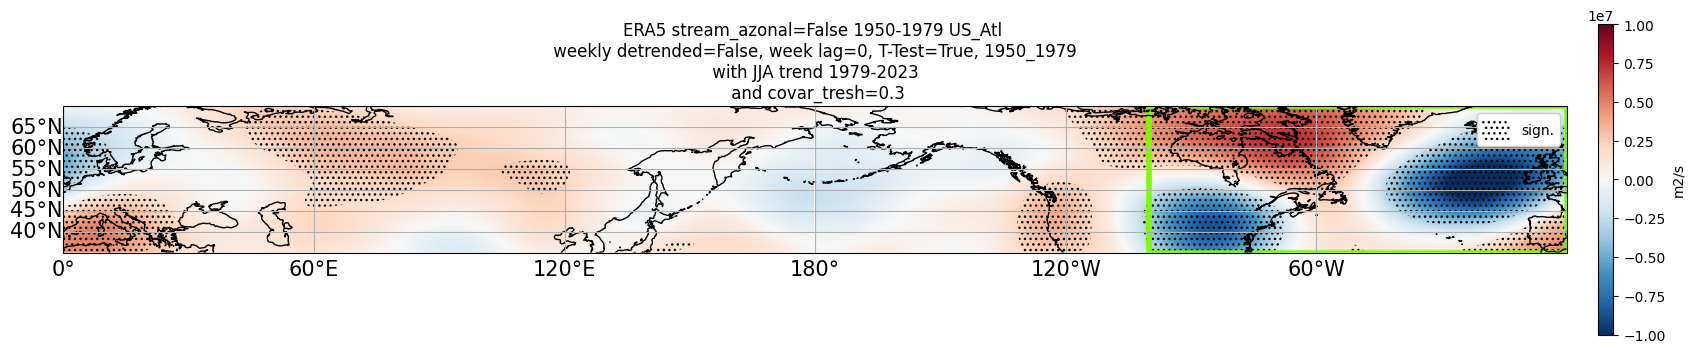

US_Atl stream 1979 2014 weekly
<xarray.DataArray 'time' (time: 3312)>
array(['1979-06-01T00:00:00.000000000', '1979-06-02T00:00:00.000000000',
       '1979-06-03T00:00:00.000000000', ..., '2014-08-29T00:00:00.000000000',
       '2014-08-30T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2014-08-31
    week     (time) int64 22 22 22 23 23 23 23 23 23 ... 34 35 35 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 474)>
array(['1979-06-03T00:00:00.000000000', '1979-06-10T00:00:00.000000000',
       '1979-06-17T00:00:00.000000000', ..., '2014-08-17T00:00:00.000000000',
       '2014-08-24T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-03 1979-06-10 ... 2014-08-31
Attributes:
    s

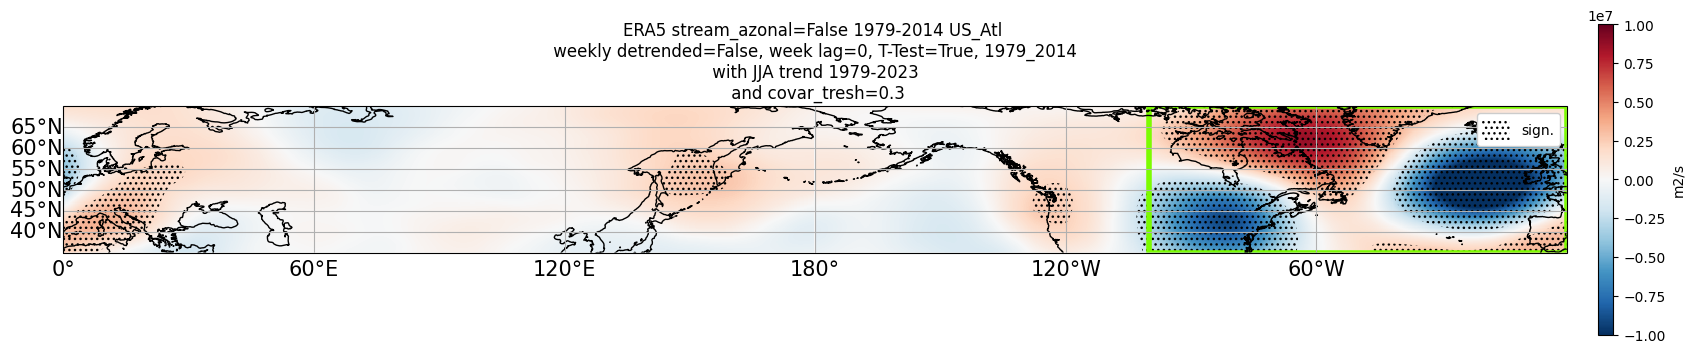

EURASIA stream 1950 1979 weekly
<xarray.DataArray 'time' (time: 2760)>
array(['1950-06-01T00:00:00.000000000', '1950-06-02T00:00:00.000000000',
       '1950-06-03T00:00:00.000000000', ..., '1979-08-29T00:00:00.000000000',
       '1979-08-30T00:00:00.000000000', '1979-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-01 1950-06-02 ... 1979-08-31
    week     (time) int64 22 22 22 22 23 23 23 23 23 ... 34 34 34 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 394)>
array(['1950-06-04T00:00:00.000000000', '1950-06-11T00:00:00.000000000',
       '1950-06-18T00:00:00.000000000', ..., '1979-08-12T00:00:00.000000000',
       '1979-08-19T00:00:00.000000000', '1979-08-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-04 1950-06-11 ... 1979-08-26
Attributes:
    

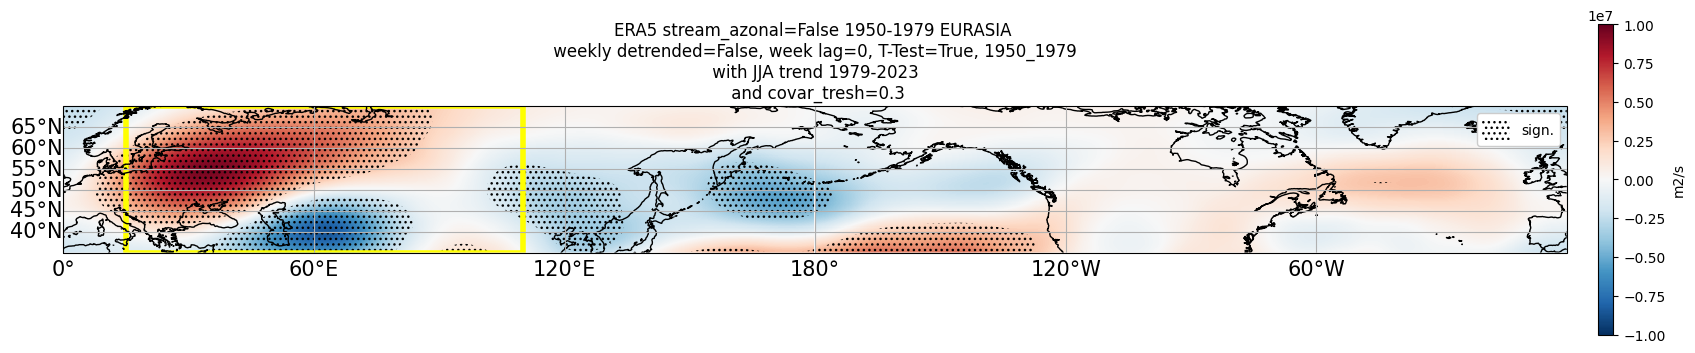

EURASIA stream 1979 2014 weekly
<xarray.DataArray 'time' (time: 3312)>
array(['1979-06-01T00:00:00.000000000', '1979-06-02T00:00:00.000000000',
       '1979-06-03T00:00:00.000000000', ..., '2014-08-29T00:00:00.000000000',
       '2014-08-30T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2014-08-31
    week     (time) int64 22 22 22 23 23 23 23 23 23 ... 34 35 35 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 474)>
array(['1979-06-03T00:00:00.000000000', '1979-06-10T00:00:00.000000000',
       '1979-06-17T00:00:00.000000000', ..., '2014-08-17T00:00:00.000000000',
       '2014-08-24T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-03 1979-06-10 ... 2014-08-31
Attributes:
    

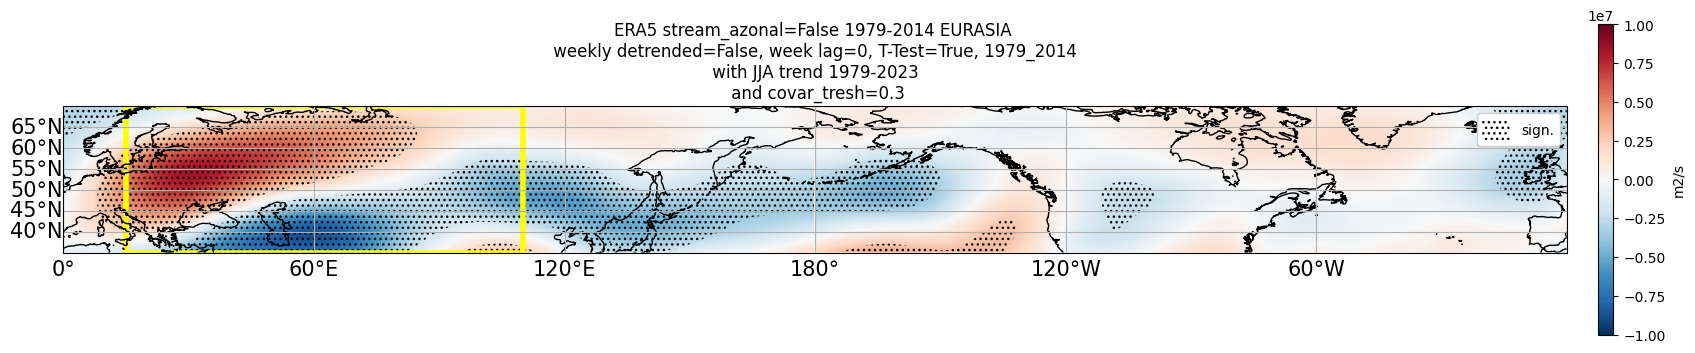

In [9]:
out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   covar_treshold=0.3,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1950, upper_year=1979)

out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   covar_treshold=0.3,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1979, upper_year=2014)

out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "EURASIA",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   covar_treshold=0.3, 
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1950, upper_year=1979)

out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "EURASIA",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   covar_treshold=0.3,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1979, upper_year=2014)

#### threshold of 0.5 

US_Atl stream 1950 1979 weekly
<xarray.DataArray 'time' (time: 2760)>
array(['1950-06-01T00:00:00.000000000', '1950-06-02T00:00:00.000000000',
       '1950-06-03T00:00:00.000000000', ..., '1979-08-29T00:00:00.000000000',
       '1979-08-30T00:00:00.000000000', '1979-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-01 1950-06-02 ... 1979-08-31
    week     (time) int64 22 22 22 22 23 23 23 23 23 ... 34 34 34 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 394)>
array(['1950-06-04T00:00:00.000000000', '1950-06-11T00:00:00.000000000',
       '1950-06-18T00:00:00.000000000', ..., '1979-08-12T00:00:00.000000000',
       '1979-08-19T00:00:00.000000000', '1979-08-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-04 1950-06-11 ... 1979-08-26
Attributes:
    s

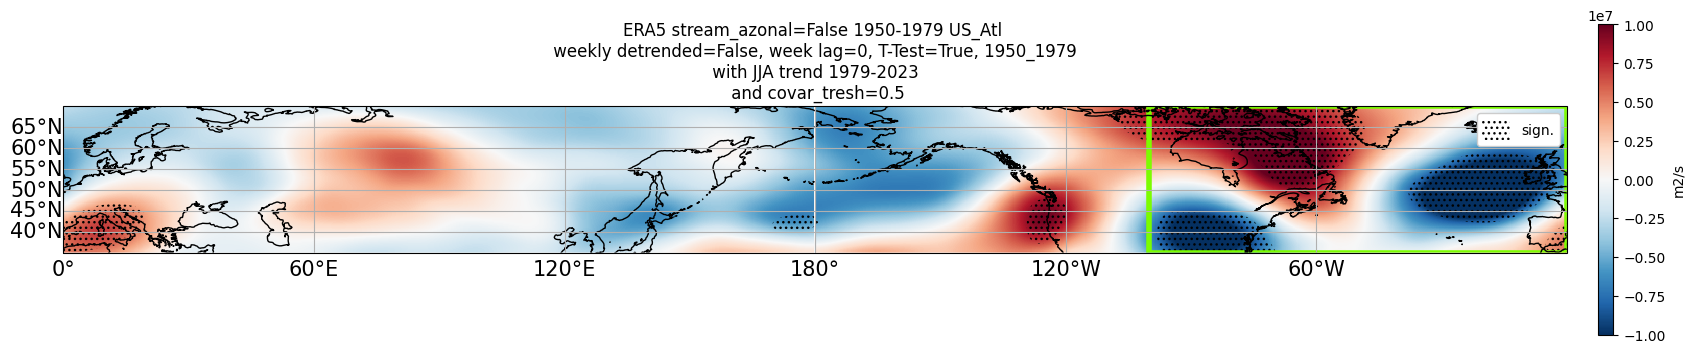

US_Atl stream 1979 2014 weekly
<xarray.DataArray 'time' (time: 3312)>
array(['1979-06-01T00:00:00.000000000', '1979-06-02T00:00:00.000000000',
       '1979-06-03T00:00:00.000000000', ..., '2014-08-29T00:00:00.000000000',
       '2014-08-30T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2014-08-31
    week     (time) int64 22 22 22 23 23 23 23 23 23 ... 34 35 35 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 474)>
array(['1979-06-03T00:00:00.000000000', '1979-06-10T00:00:00.000000000',
       '1979-06-17T00:00:00.000000000', ..., '2014-08-17T00:00:00.000000000',
       '2014-08-24T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-03 1979-06-10 ... 2014-08-31
Attributes:
    s

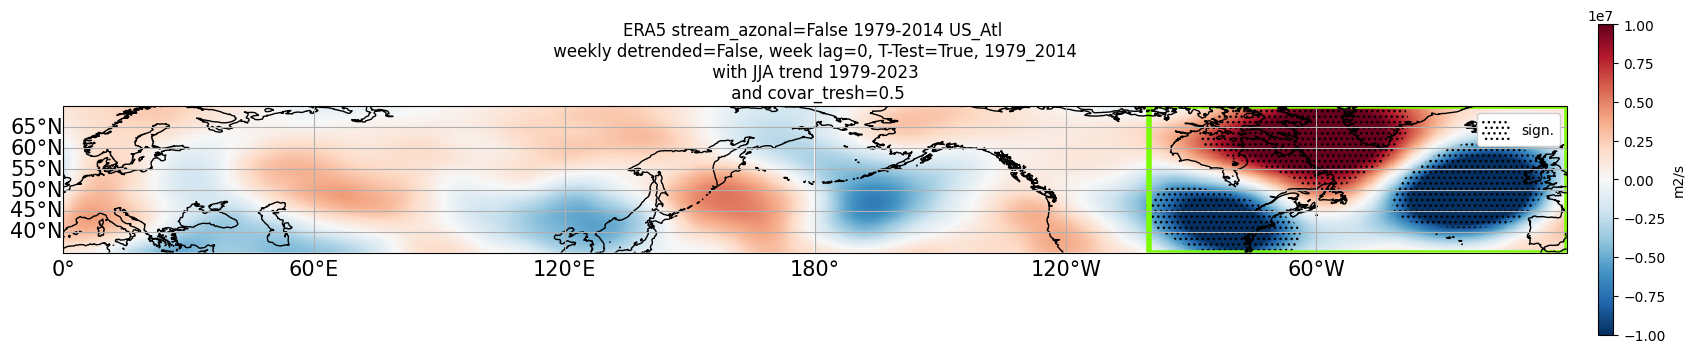

EURASIA stream 1950 1979 weekly
<xarray.DataArray 'time' (time: 2760)>
array(['1950-06-01T00:00:00.000000000', '1950-06-02T00:00:00.000000000',
       '1950-06-03T00:00:00.000000000', ..., '1979-08-29T00:00:00.000000000',
       '1979-08-30T00:00:00.000000000', '1979-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-01 1950-06-02 ... 1979-08-31
    week     (time) int64 22 22 22 22 23 23 23 23 23 ... 34 34 34 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 394)>
array(['1950-06-04T00:00:00.000000000', '1950-06-11T00:00:00.000000000',
       '1950-06-18T00:00:00.000000000', ..., '1979-08-12T00:00:00.000000000',
       '1979-08-19T00:00:00.000000000', '1979-08-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-06-04 1950-06-11 ... 1979-08-26
Attributes:
    

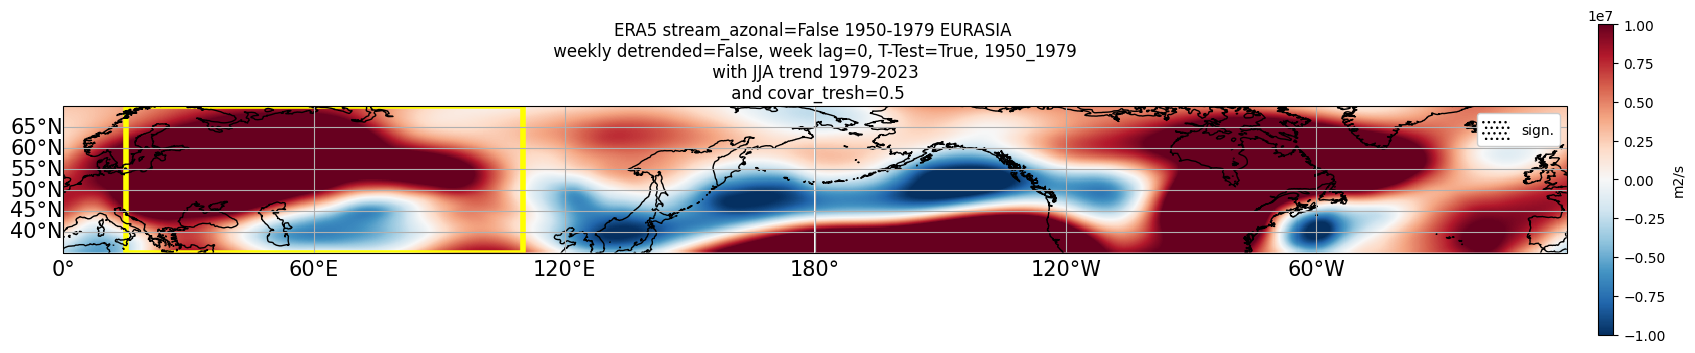

EURASIA stream 1979 2014 weekly
<xarray.DataArray 'time' (time: 3312)>
array(['1979-06-01T00:00:00.000000000', '1979-06-02T00:00:00.000000000',
       '1979-06-03T00:00:00.000000000', ..., '2014-08-29T00:00:00.000000000',
       '2014-08-30T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2014-08-31
    week     (time) int64 22 22 22 23 23 23 23 23 23 ... 34 35 35 35 35 35 35 35
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 474)>
array(['1979-06-03T00:00:00.000000000', '1979-06-10T00:00:00.000000000',
       '1979-06-17T00:00:00.000000000', ..., '2014-08-17T00:00:00.000000000',
       '2014-08-24T00:00:00.000000000', '2014-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-06-03 1979-06-10 ... 2014-08-31
Attributes:
    

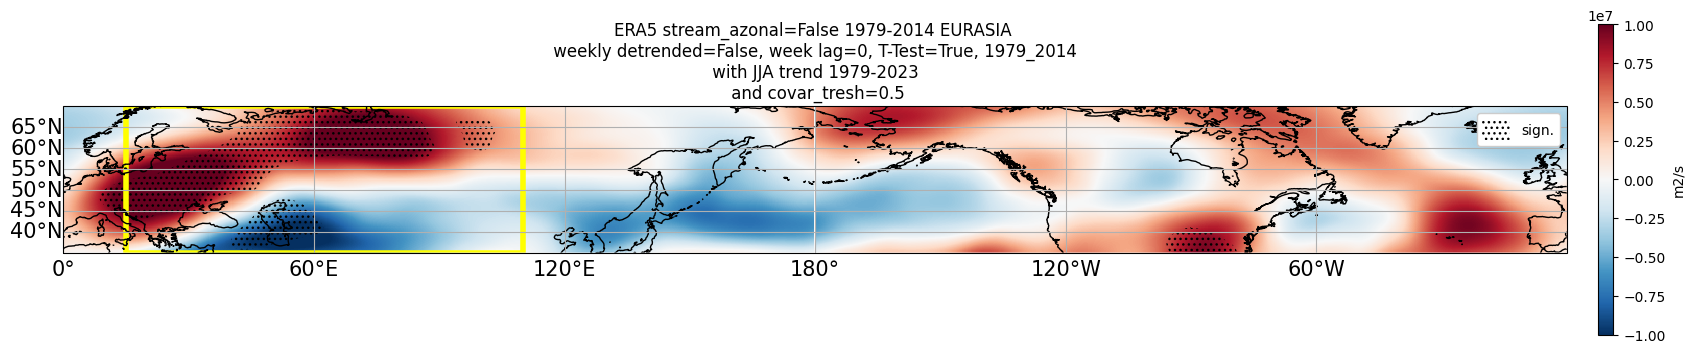

In [17]:
out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1950, upper_year=1979)

out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "US_Atl",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1979, upper_year=2014)

out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "EURASIA",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1950, upper_year=1979)

out, pvals  = create_composites_ERA5_revised_nosavefig("stream", 
                   "EURASIA",
                   daJJA_removed_seasonality,
                   daJJA_cut_trend,
                   stream_azonal=False,
                   week_lags=[0],
                 lower_year=1979, upper_year=2014)

In [9]:
out[0]

[<xarray.DataArray (time: 1, latitude: 141, longitude: 1440)>
 array([[[ -608381.75   ,  -565067.125  ,  -521940.4375 , ...,
           -739452.4375 ,  -695620.     ,  -651952.125  ],
         [ -588632.6875 ,  -544367.5625 ,  -500358.875  , ...,
           -722380.3125 ,  -677612.6875 ,  -633044.6875 ],
         [ -568811.125  ,  -523776.4375 ,  -478860.65625, ...,
           -705193.     ,  -659610.     ,  -614100.75   ],
         ...,
         [-3060748.5    , -3016961.25   , -2970609.     , ...,
          -3176682.25   , -3140799.5    , -3102073.75   ],
         [-2938939.5    , -2898037.25   , -2854613.     , ...,
          -3045723.     , -3012836.     , -2977229.25   ],
         [-2819916.5    , -2781936.5    , -2741210.25   , ...,
          -2917678.25   , -2887851.     , -2855256.5    ]]])
 Coordinates:
   * time       (time) int64 0
   * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
   * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 